<a href="https://colab.research.google.com/github/cristhiamdaniel-cj/DataInsightFlow-PUJ/blob/main/DataInsightFlow_PLN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pysentimiento

In [ ]:
!pip install pymongo[srv]

In [ ]:
!pip install load_dotenv

In [ ]:
!pip install matplotlib


In [ ]:
!pip install gensim nltk

In [ ]:
!!pip install wordcloud


In [ ]:
from pysentimiento import create_analyzer
analyzer = create_analyzer(task="sentiment", lang="es")


In [ ]:


analyzer.predict("Qué gran jugador es Messi")

AnalyzerOutput(output=POS, probas={POS: 0.946, NEU: 0.037, NEG: 0.017})

In [9]:
from pymongo import MongoClient
import os
from dotenv import load_dotenv

# Carga las variables de entorno desde el archivo .env subido a Colab
load_dotenv('.env')

# Extrae las variables de entorno
MONGO_URI = os.getenv("MONGO_URI")
DB_NOMBRE = "BancoTweets"
COLLECTION_NAME = "tweets_BancoAVVillas_transformados"

# Inicializa el cliente de MongoDB con la URI obtenida del archivo .env
client = MongoClient(MONGO_URI)

# Selecciona la base de datos y la colección específicas
db = client[DB_NOMBRE]
collection = db[COLLECTION_NAME]

# Ejecuta una consulta de prueba para verificar la conexión y obtener algún dato
# Por ejemplo, contar el número de documentos en la colección
document_count = collection.count_documents({})

print(f"Conectado a MongoDB. Número de documentos en la colección '{COLLECTION_NAME}': {document_count}")


Conectado a MongoDB. Número de documentos en la colección 'tweets_BancoAVVillas_transformados': 315


In [18]:
from pysentimiento.preprocessing import preprocess_tweet
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
import emoji

nltk.download('stopwords')

# Extracción de todos los documentos/tweets de la colección
tweets = collection.find()

# Configuración inicial para español
stop_words = set(stopwords.words('spanish'))
stemmer = SnowballStemmer('spanish')

def limpiar_tweet(tweet):
    tweet = tweet.lower()  # Convertir a minúsculas
    tweet = re.sub(r'@\w+', '', tweet)  # Eliminar menciones
    tweet = re.sub(r'http\S+', '', tweet)  # Eliminar URLs
    tweet = emoji.replace_emoji(tweet, replace='')  # Eliminar emojis
    tweet = re.sub(r'#(\w+)', r'\1', tweet)  # Convertir hashtags a texto
    tweet = re.sub(r'\d+', '', tweet)  # Eliminar números
    # tweet = re.sub(r'[^\w\s]', '', tweet)  # Eliminar puntuación
    palabras = tweet.split()
    palabras_filtradas = [palabra for palabra in palabras if palabra not in stop_words and len(palabra) > 2]
    tweet_limpio = ' '.join(palabras_filtradas)
    return tweet_limpio

# Ahora, en tu bucle de procesamiento, utiliza la función `limpiar_tweet` en lugar de `preprocess_tweet` directamente:
tweets_limpios = [limpiar_tweet(tweet['tweet_text']) for tweet in tweets]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:

# Verifica la cantidad de tweets procesados y muestra los primeros 5 para revisión
print(f"Total de tweets procesados y limpios: {len(tweets_limpios)}")
print("Primeros 5 tweets limpios:")
for tweet in tweets_limpios[:5]:
    print(tweet)

Total de tweets procesados y limpios: 315
Primeros 5 tweets limpios:
profundamente decepcionada mala atención apoyo hermano recibido frente transacciones fraudulentas cuenta ahorros banco villas. visto afectado salud mental financiera, inaceptable.
necesito respuestas robo cuenta banco avvillas enero
¡deja ponerlo lista propósitos hazlo realidad! estudia apasiona, cumple metas solicitando crédito libre inversión banco bogotá. apoyamos deseos fin año hagan realidad.
ademas brinden seguridad virtual. respondan malos procesos robos cuentas ahorros, necwsito devuelvan dinero robado bancoavvillas hace mes respuesta solo ustd culpable... impotencia
bancoavvillas partida aliados crimen avvillasladrones, robaron dinero cuenta solo responden "no responden favorablemente" ven segun estudios sospechoso... necesitamos dinero vuelta


In [21]:
from pysentimiento import create_analyzer
import matplotlib.pyplot as plt

analyzer = create_analyzer(task="sentiment", lang="es")

# Analiza los sentimientos de los tweets limpios
resultados_sentimientos = [analyzer.predict(tweet) for tweet in tweets_limpios]

# Extrae el sentimiento principal (POS, NEG, NEU) de cada resultado
sentimientos = [resultado.output for resultado in resultados_sentimientos]


In [22]:
from collections import Counter

conteo_sentimientos = Counter(sentimientos)

# Nombres de las categorías
categorias = list(conteo_sentimientos.keys())

# Cantidad de tweets por categoría
valores = list(conteo_sentimientos.values())


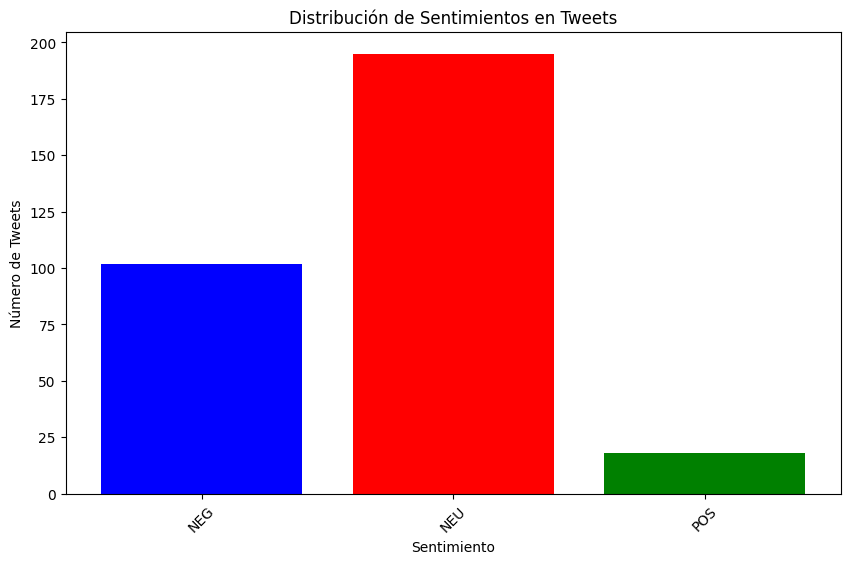

In [23]:
plt.figure(figsize=(10, 6))
plt.bar(categorias, valores, color=['blue', 'red', 'green'])

plt.title('Distribución de Sentimientos en Tweets')
plt.xlabel('Sentimiento')
plt.ylabel('Número de Tweets')
plt.xticks(rotation=45)
plt.show()


In [26]:
from gensim import corpora, models
import nltk
from nltk.corpus import stopwords
import re

# Suponiendo que tweets_limpios es tu lista de tweets preprocesados
# tweets_limpios = [...]

# Descarga las stopwords si aún no lo has hecho
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

# Preprocesamiento adicional si es necesario
def preprocesar_texto(texto):
    # Implementa aquí cualquier paso adicional de preprocesamiento si es necesario
    texto = re.sub(r'\W', ' ', texto.lower())
    texto = re.sub(r'\s+[a-zA-Z]\s+', ' ', texto)
    texto = re.sub(r'\^[a-zA-Z]\s+', ' ', texto)
    texto = re.sub(r'\s+', ' ', texto, flags=re.I)
    texto = re.sub(r'^b\s+', '', texto)
    texto = ' '.join([palabra for palabra in texto.split() if palabra not in stop_words])
    return texto

tweets_procesados = [preprocesar_texto(tweet) for tweet in tweets_limpios]

# Crear un diccionario y corpus necesarios para LDA
diccionario = corpora.Dictionary([tweet.split() for tweet in tweets_procesados])
corpus = [diccionario.doc2bow(tweet.split()) for tweet in tweets_procesados]

# Aplicar LDA
NUM_TOPICS = 5  # Define el número de tópicos que quieres extraer
lda_model = models.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=diccionario, passes=15)

# Mostrar los tópicos
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(0, '0.073*"banco" + 0.068*"villas" + 0.022*"peticiones" + 0.019*"aceb" + 0.015*"tarjeta"')
(1, '0.054*"banco" + 0.044*"villas" + 0.022*"cuenta" + 0.012*"solo" + 0.012*"mil"')
(2, '0.028*"dinero" + 0.028*"responden" + 0.026*"banco" + 0.023*"villas" + 0.017*"deudas"')
(3, '0.066*"banco" + 0.050*"villas" + 0.016*"cuenta" + 0.016*"enero" + 0.012*"ahorros"')
(4, '0.030*"banco" + 0.030*"crédito" + 0.025*"bogotá" + 0.025*"realidad" + 0.020*"tarjeta"')


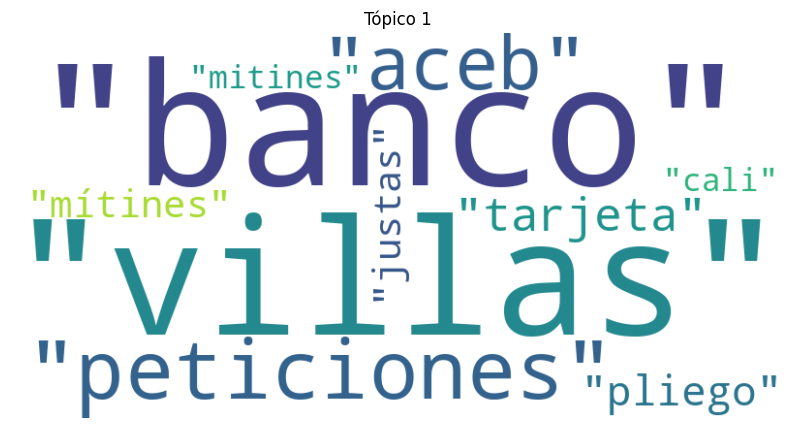

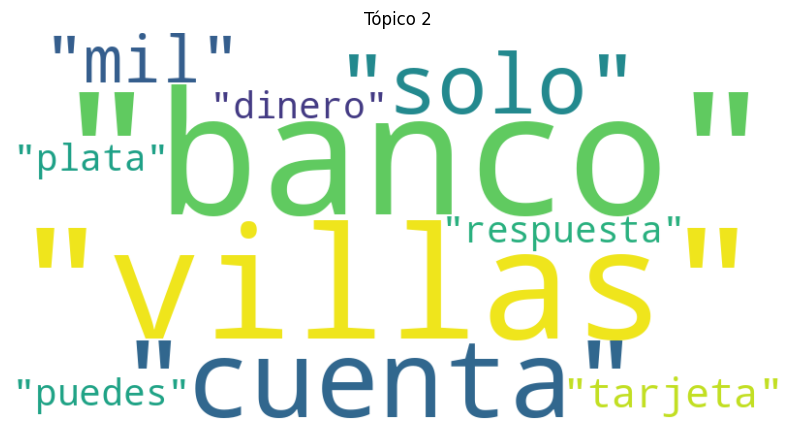

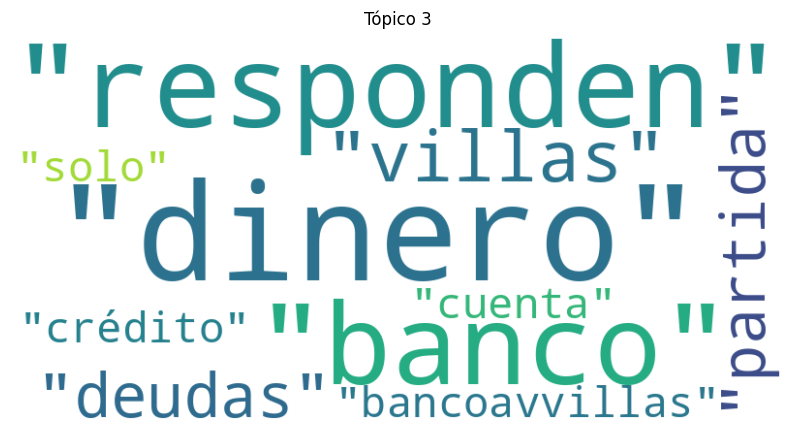

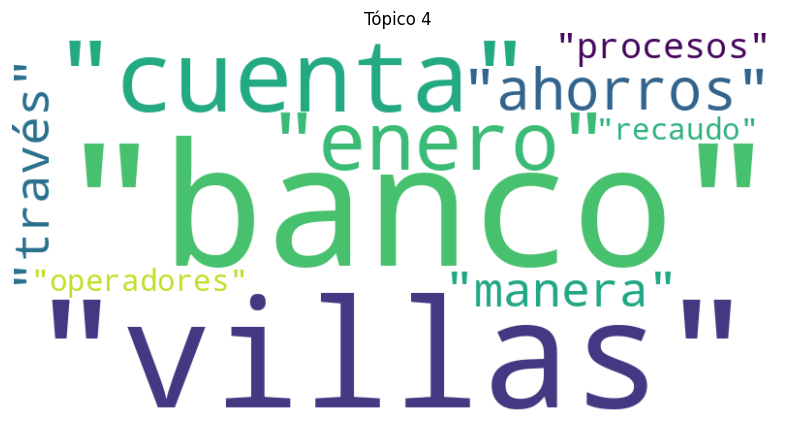

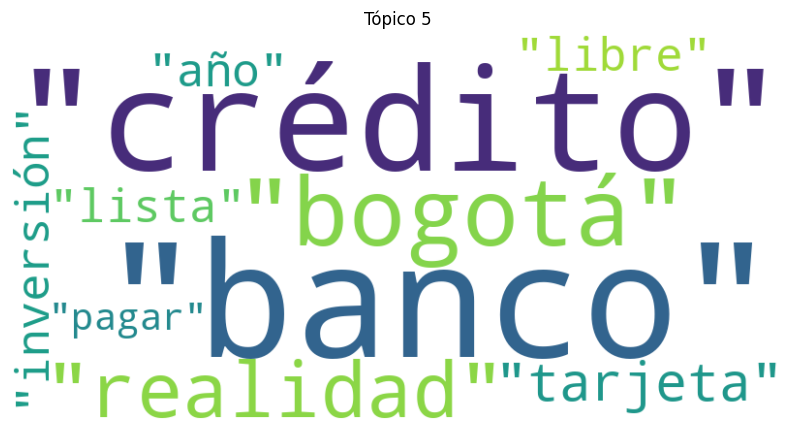

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generar una nube de palabras para cada tópico
for i, topic in enumerate(lda_model.show_topics(num_topics=NUM_TOPICS, num_words=10)):
    # Extraer solo las palabras de cada tópico (sin los pesos)
    words = dict([word, float(value)] for value, word in map(lambda kv: kv.split("*"), topic[1].split(" + ")))
    # Generar la nube de palabras
    wordcloud = WordCloud(background_color='white', width=800, height=400)
    wordcloud.generate_from_frequencies(words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Tópico {i + 1}')
    plt.show()


In [30]:
!git clone https://github.com/cristhiamdaniel-cj/DataInsightFlow-PUJ.git


Cloning into 'DataInsightFlow-PUJ'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 75 (delta 25), reused 66 (delta 19), pack-reused 0
Receiving objects: 100% (75/75), 167.78 KiB | 5.79 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [31]:
%ls


DataInsightFlow-PUJ/  sample_data/


In [32]:
%cd DataInsightFlow-PUJ/

/content/DataInsightFlow-PUJ


In [34]:
%cd ..
%cd sample_data/
%ls

/content
/content/sample_data
anscombe.json*               california_housing_train.csv  mnist_train_small.csv
california_housing_test.csv  mnist_test.csv                README.md*


In [37]:
%cd /content/sample_data
%ls

/content/sample_data
anscombe.json*               california_housing_train.csv  mnist_train_small.csv
california_housing_test.csv  mnist_test.csv                README.md*


In [29]:
!git add .
!git commit -m "Procesamiento Lenguaje Natural"
!git push


fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


In [39]:
%ls

anscombe.json*               california_housing_train.csv  mnist_train_small.csv
california_housing_test.csv  mnist_test.csv                README.md*
